Implement the Sparse auto-encoder and the Contractive Auto-encoder. Use the MNIST digit dataset for
training your network. Use the U-Net auto-encoder architecture for encoder and decoder without skip
connections. Let E be the trained encoder and D be the trained decoder, h = E(I) be the embedding of
an image I and let ˆI = D(h) be the output of the decoder.
(a) (20 points) Plot the t-sne (use inbuilt function) on the embeddings obtained using the respective
auto-encoders. Color the clusters using the respective ground-truth class labels.
(b) (20 points) Randomly take two images I1 and I2 from two different digit classes. Let h1 = E(I1)
and h2 = E(I2) be the embeddings for these images, respectively. Construct another image Iα =
αI1+(1−α)I2 for α = 0, 0.2, 0.4, 0.6, 0.8, 1. Find the embedding hα of this image Iα for all values of α
by passing it through the encoder. Also, consider the approximate embedding h
′
α = αh1 + (1−α)h2
by using directly the embeddings of the images I1 and I2. Also, find ˆIα = D(hα) and ˆI
′
α = D(h
′
α).
Plot the images ˆIα and ˆI
′
α side by side for different values of α. Do this for 20 pairs (I1, I2). Report
PSNR between ˆIα and ˆI
′
α and find ∥hˆ
α − hˆ′
α∥2 for all values of alpha.
(c) (20 points) After training the autoencoders, you want to check if the embeddings of different digits
are different and embeddings within a class are similar. For this purpose, you propose to perform
the classification of the digits based on the embeddings obtained by the encoders and check the
accuracy of classifications for each of the Auto-encoder. Report the classification accuracy for each
of the AE and report which one is better. Use any inbuilt classifier to solve the classification
problem.

In [1]:
%pip install tensorflow numpy pandas matplotlib scikit-learn seaborn

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
import numpy as np

In [42]:
# Hyperparameters
batch_size = 128
epochs = 20
learning_rate = 0.001
sparse_lambda = 1e-3  # Sparsity penalty
contractive_lambda = 1e-4  # Contractive penalty
rho = 0.05  # Target sparsity
input_dim = 784
hidden_dim = 64
sparsity_level = 0.05
lambda_sparse = 0.1

# Load and preprocess MNIST dataset
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape((x_train.shape[0], -1)).astype('float32') / 255.0
x_test = x_test.reshape((x_test.shape[0], -1)).astype('float32') / 255.0

In [53]:
import tensorflow as tf

def encoder_block(inputs, num_filters):
    x = layers.Conv2D(num_filters, 3, padding='same')(inputs)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(num_filters, 3, padding='same')(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D(pool_size=(2, 2), strides=2)(x)
    return x

def decoder_block(inputs, num_filters):
    x = layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding='same')(inputs)
    x = layers.Conv2D(num_filters, 3, padding='same')(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(num_filters, 3, padding='same')(x)
    x = layers.Activation('relu')(x)
    return x

class UNetAutoEncoderArchitecture():
    def build_encoder(self, input_shape=(28, 28, 1)):
        inputs = layers.Input(shape=input_shape)
        x = encoder_block(inputs, 64)
        x = encoder_block(x, 128)
        x = encoder_block(x, 256)
        return models.Model(inputs=inputs, outputs=x, name='encoder')

    def build_decoder(self, input_shape=(128,)):
        inputs = layers.Input(shape=input_shape)
        x = layers.Dense(4*4*256, activation='relu')(inputs)
        x = layers.Reshape((4, 4, 256))(x)
        x = decoder_block(x, 256)
        x = decoder_block(x, 128)
        x = decoder_block(x, 64)
        outputs = layers.Conv2D(1, 1, padding='same', activation='sigmoid')(x)
        return models.Model(inputs=inputs, outputs=outputs, name='decoder')

def unet_model(input_shape=(28, 28, 1), num_classes=1):
    inputs = layers.Input(shape=input_shape)
    # Contracting Path (Encoder)
    s1 = encoder_block(inputs, 64)
    s2 = encoder_block(s1, 128)
    s3 = encoder_block(s2, 256)

    # Bottleneck
    b1 = tf.keras.layers.Conv2D(256, 3, padding='valid')(s3)
    b1 = tf.keras.layers.Activation('relu')(b1)
    b1 = tf.keras.layers.Conv2D(256, 3, padding='valid')(b1)
    b1 = tf.keras.layers.Activation('relu')(b1)

    # Expansive Path (Decoder)
    d1 = decoder_block(b1, s3, 256)
    d2 = decoder_block(d1, s3, 128)
    d3 = decoder_block(d2, s2, 64)

    outputs = tf.keras.layers.Conv2D(num_classes, 1, padding='valid', activation='sigmoid')(d3)
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name='U-Net')
    return model


In [55]:
inputs = layers.Input(shape=(784,))
encoded = layers.Dense(64, activation='relu')(inputs)
decoded = layers.Dense(784, activation='sigmoid')(encoded)

autoencoder = tf.keras.Model(inputs, decoded)
encoder = tf.keras.Model(inputs, encoded)

In [45]:
def sparse_loss(y_true, y_pred):
    mse_loss = tf.reduce_mean(tf.keras.losses.MeanSquaredError()(y_true, y_pred))
    hidden_layer_output = encoder(y_true)
    mean_activation = tf.reduce_mean(hidden_layer_output, axis=0)

    kl_divergence = tf.reduce_sum(sparsity_level * tf.math.log(sparsity_level / (mean_activation + 1e-10)) +
                                  (1 - sparsity_level) * tf.math.log((1 - sparsity_level) / (1 - mean_activation + 1e-10)))

    return mse_loss + lambda_sparse * kl_divergence

In [46]:
autoencoder.compile(optimizer='adam', loss=sparse_loss)

In [47]:
history = autoencoder.fit(x_train, x_train, epochs=50, batch_size=256, shuffle=True)

Epoch 1/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.2694
Epoch 2/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1116
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0794
Epoch 4/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0653
Epoch 5/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0576
Epoch 6/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0529
Epoch 7/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0494
Epoch 8/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0469
Epoch 9/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0451
Epoch 10/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0433
Epoch 11/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0416
Epoch 12/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0417
Epoch 13/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0404
Epoch 14/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0388
Epoch 15/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - lo

In [48]:
reconstructed = autoencoder.predict(x_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


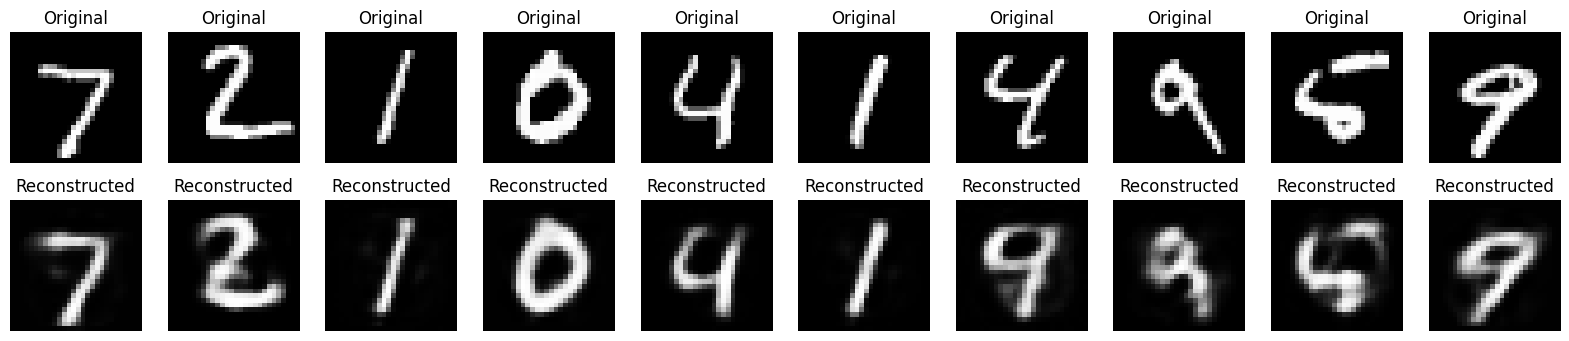

In [50]:
import matplotlib.pyplot as plt
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Reconstructed images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed[i].reshape(28, 28), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')
plt.show()